# Decision Tree

## 0. Setup

### 0.1. Install packages

In [1]:
# Install required packages
#!pip install seaborn
#%pip install -q pandas matplotlib numpy scikit-learn
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

### 0.2. Load packages

In [3]:
# from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import random

from panelsplit.cross_validation import PanelSplit

import shap
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import zipfile
import openpyxl

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit  # Alternative to PanelSplit

### 0.4. Load Data

In [4]:
### Check working directory
#print(os.getcwd()) 

### Define file and path
#file_path = r"c:\Users\mmier\OneDrive - Hertie School\3. Estudio\2025 MDS\2025-1 MDS Thesis\MDS_thesis\Data" #Use a raw string (r"") when defining paths
#print(os.listdir(file_path)) # List files in directory
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"
#full_path = os.path.join(file_path, csv_filename)

# Extract the CSV file from the ZIP
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extract(csv_filename)

# Read the CSV file into a DataFrame
final_df = pd.read_csv("final_df.csv")

# Delete the extracted CSV file after reading
os.remove("final_df.csv")

# Feature names
final_df_feature_names = list(final_df.columns) 
print(final_df_feature_names)



['codmpio', 'cluster_kmeans', 'Departamento', 'Municipio', 'Region', 'year', 'f_loss', 'pc_loss', 'areaoficialhm2', 'gdp', 'gdp_pc', 'iica', 'fisc_perf', 'discapital', 'dismdo', 'disbogota', 'pobl_rur', 'pobl_urb', 'total_ac', 'total_as', 'total_p', 'total_r', 'total_nuf', 'total_vrf', 'H_coca', 'errad_manual', 'terrorismot', 'pirateria_terr', 'e_amenaza', 'e_confina', 'e_delito_sex', 'e_desap_for', 'e_desplaza', 'e_minas_anti', 'e_tortura', 'e_vinc_mened', 'eventos_minas', 'ICM-00-0', 'PCC-00-0', 'GPI-00-0', 'EIS-00-0', 'CTI-00-0', 'SEG-00-0', 'SOS-00-0', 'CTI-01-0', 'CTI-02-0', 'CV-01-1', 'CV-01-11', 'CTI-02-3', 'CTI-02-2', 'CTI-02-4', 'C-02-8t', 'CTI-01-3', 'SOS-01-0', 'SOS-02-0', 'SOS-03-0', 'M-03-15', 'SOS-01-6', 'SOS-02-2', 'M-03-24', 'SOS-03-5a', 'SOS-03-6', 'CV-03-16', 'CV-03-51', 'CV-03-54', 'SEG-01-9', 'CV-03-36', 'SEG-01-6', 'CV-03-41', 'CV-03-44', 'CV-03-47', 'EIS-01-0', 'EIS-02-0', 'EIS-03-0', 'CV-02-12e', 'CV-03-31e', 'CV-01-15', 'CV-03-64', 'CV-03-65Aj', 'EIS-03-1', 'CV-

## 1. Preprocess

### 1.1. Define train, test and evaluation set

Evaluation set: 2019 to 2022

In [ ]:
### Separate evaluation set 
#final_df = df[df["AÑO"] < 2019]

### 1.2. Define y and X1

y: deforestation

X1: general variables

In [5]:
# y 
y = final_df['pc_loss']
y = np.log1p(final_df['pc_loss'])
#y = y.to_numpy()

# Normalize output
#scaler = StandardScaler()

# X final
X1 = final_df.drop(columns=['year', 'codmpio', 'cluster_kmeans', 'Departamento', 'Municipio', 'Region', 'pc_loss', 'f_loss', 'areaoficialhm2', 'gdp']) # GDP, area already out since the were already considered
X1 = X1.drop(columns=['CV-01-15','CV-03-64', 'CV-03-26b', 'CV-01-11', 'CV-01-1', 'PCC-02-0', 'PCC-02-3', 'EIS-00-0', 'PCC-00-0', 'CTI-00-0', 'C-02-8t', 'ICM-00-0',
                      'EIS-03-4', 'CTI-01-3', 'SEG-00-0', 'SEG-01-6', 'SOS-00-0', 'SOS-02-0', 'SOS-02-2', 'SOS-01-6', 'GPI-00-0', 'GPI-02-4', 'GPI-02-5', 'P-01-34-1',
                      'P-01-46', 'P-01-25', 'CV-02-12e', 'CV-03-51', 'total_ac']) 


# Keep feature names
original_feature_names = list(X1.columns) 
print(original_feature_names)

# Normalize features
#X1 = scaler.fit_transform(X1)

['gdp_pc', 'iica', 'fisc_perf', 'discapital', 'dismdo', 'disbogota', 'pobl_rur', 'pobl_urb', 'total_as', 'total_p', 'total_r', 'total_nuf', 'total_vrf', 'H_coca', 'errad_manual', 'terrorismot', 'pirateria_terr', 'e_amenaza', 'e_confina', 'e_delito_sex', 'e_desap_for', 'e_desplaza', 'e_minas_anti', 'e_tortura', 'e_vinc_mened', 'eventos_minas', 'CTI-01-0', 'CTI-02-0', 'CTI-02-3', 'CTI-02-2', 'CTI-02-4', 'SOS-01-0', 'SOS-03-0', 'M-03-15', 'M-03-24', 'SOS-03-5a', 'SOS-03-6', 'CV-03-16', 'CV-03-54', 'SEG-01-9', 'CV-03-36', 'CV-03-41', 'CV-03-44', 'CV-03-47', 'EIS-01-0', 'EIS-02-0', 'EIS-03-0', 'CV-03-31e', 'CV-03-65Aj', 'EIS-03-1', 'CV-03-26', 'CV-03-27', 'EIS-03-3', 'GPI-01-0', 'GPI-02-0', 'GPI-03-0', 'INS-02-15', 'INS-02-16', 'GPI-01-2', 'GPI-01-3', 'INS-01-8c', 'INS-01-9', 'GPI-02-3', 'PCC-01-0', 'PCC-03-0', 'PCC-01-2', 'PCC-02-1', 'C-03-14', 'PCC-02-3a', 'PCC-02-4', 'C-03-13']


## 2. Decision Tree

## 3. Tunning

## Plot

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor

### Adjusted R² function
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

# Define hyperparameter grid for DecisionTreeRegressor
param_grid = {
    "max_depth": [5, 10, 20, None],  
    "min_samples_split": [2, 5, 10],  
    "min_samples_leaf": [1, 2, 4],
}

# Define the model (no hyperparameters here — GridSearchCV will handle it)
model = DecisionTreeRegressor(random_state=17)


### Setup panel data cross-validation
panel_split = PanelSplit(periods=final_df.year, n_splits=3, gap=0, test_size=1)
groups = X1.index  # Using index since Municipio was dropped


# Setup GridSearchCV with PanelSplit cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Minimize MSE
    cv=panel_split.split(X1, y),  # Custom panel CV
    n_jobs=-1,  # Parallel computation
    verbose=2
)

# Run grid search
grid_search.fit(X1, y)

# Extract best model and hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Store results for best hyperparameters
results = []

# Iterate through each fold for evaluation
for train_idx, test_idx in panel_split.split(X1, y):
    # Split data
    X1_train, X1_test = X1.iloc[train_idx], X1.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train the best model on the current fold
    best_model.fit(X1_train, y_train)

    # Make predictions
    y_train_pred = best_model.predict(X1_train)
    y_test_pred = best_model.predict(X1_test)

    # Compute performance metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Compute Adjusted R²
    n_train, k = X1_train.shape
    n_test = X1_test.shape[0]
    adj_r2_train = adjusted_r2(r2_train, n_train, k)
    adj_r2_test = adjusted_r2(r2_test, n_test, k)

    # Store results
    results.append({
        "MSE": mse_test,
        "RMSE": rmse_test,
        "MAE": mae_test,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "Adj_R2_train": adj_r2_train,
        "Adj_R2_test": adj_r2_test
    })

# Compute average performance across folds
best_metrics = {metric: np.mean([fold[metric] for fold in results]) for metric in results[0].keys()}

### Print optimal hyperparameters and performance
#print(f"🌲 Best Random Forest Parameters: n_estimators={best_params['n_estimators']}, max_depth={best_params['max_depth']}")
print(f"📊 Best MSE: {best_metrics['MSE']:.4f}")
print(f"📊 Best RMSE: {best_metrics['RMSE']:.4f}")
print(f"📊 Best MAE: {best_metrics['MAE']:.4f}")
print(f"📊 R² (Train): {best_metrics['R2_train']:.4f}")
print(f"📊 R² (Test): {best_metrics['R2_test']:.4f}")
print(f"📊 Adj. R² (Train): {best_metrics['Adj_R2_train']:.4f}")
print(f"📊 Adj. R² (Test): {best_metrics['Adj_R2_test']:.4f}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
📊 Best MSE: 0.0078
📊 Best RMSE: 0.0879
📊 Best MAE: 0.0409
📊 R² (Train): 0.7391
📊 R² (Test): 0.3671
📊 Adj. R² (Train): 0.7374
📊 Adj. R² (Test): 0.3247


In [9]:
np.unique(y_test_pred)


array([0.00237142, 0.00539438, 0.00601696, 0.00682109, 0.00861645,
       0.01067178, 0.01079368, 0.01143078, 0.01267854, 0.01379446,
       0.01413776, 0.01484849, 0.01640817, 0.01714992, 0.01785707,
       0.01933693, 0.02340203, 0.02367667, 0.02396892, 0.02420661,
       0.02457019, 0.03024701, 0.03195019, 0.03325302, 0.04033854,
       0.040362  , 0.04233974, 0.04596777, 0.04705721, 0.05070439,
       0.05450898, 0.05549793, 0.06067641, 0.06284699, 0.06425491,
       0.0664756 , 0.06659947, 0.07010471, 0.07076271, 0.07488703,
       0.08570747, 0.08869513, 0.09093074, 0.0984594 , 0.10076151,
       0.10274746, 0.10455257, 0.11433865, 0.11738422, 0.12447003,
       0.12542248, 0.13525241, 0.14169927, 0.14555658, 0.15057307,
       0.15570247, 0.1626767 , 0.16496431, 0.17364417, 0.1873713 ,
       0.20395868, 0.20485086, 0.20872033, 0.22686549, 0.22690551,
       0.22991647, 0.23065179, 0.23376808, 0.25589399, 0.26232649,
       0.2737788 , 0.27549503, 0.28778175, 0.28971087, 0.29248

Number of leaves: 208
Tree depth: 10


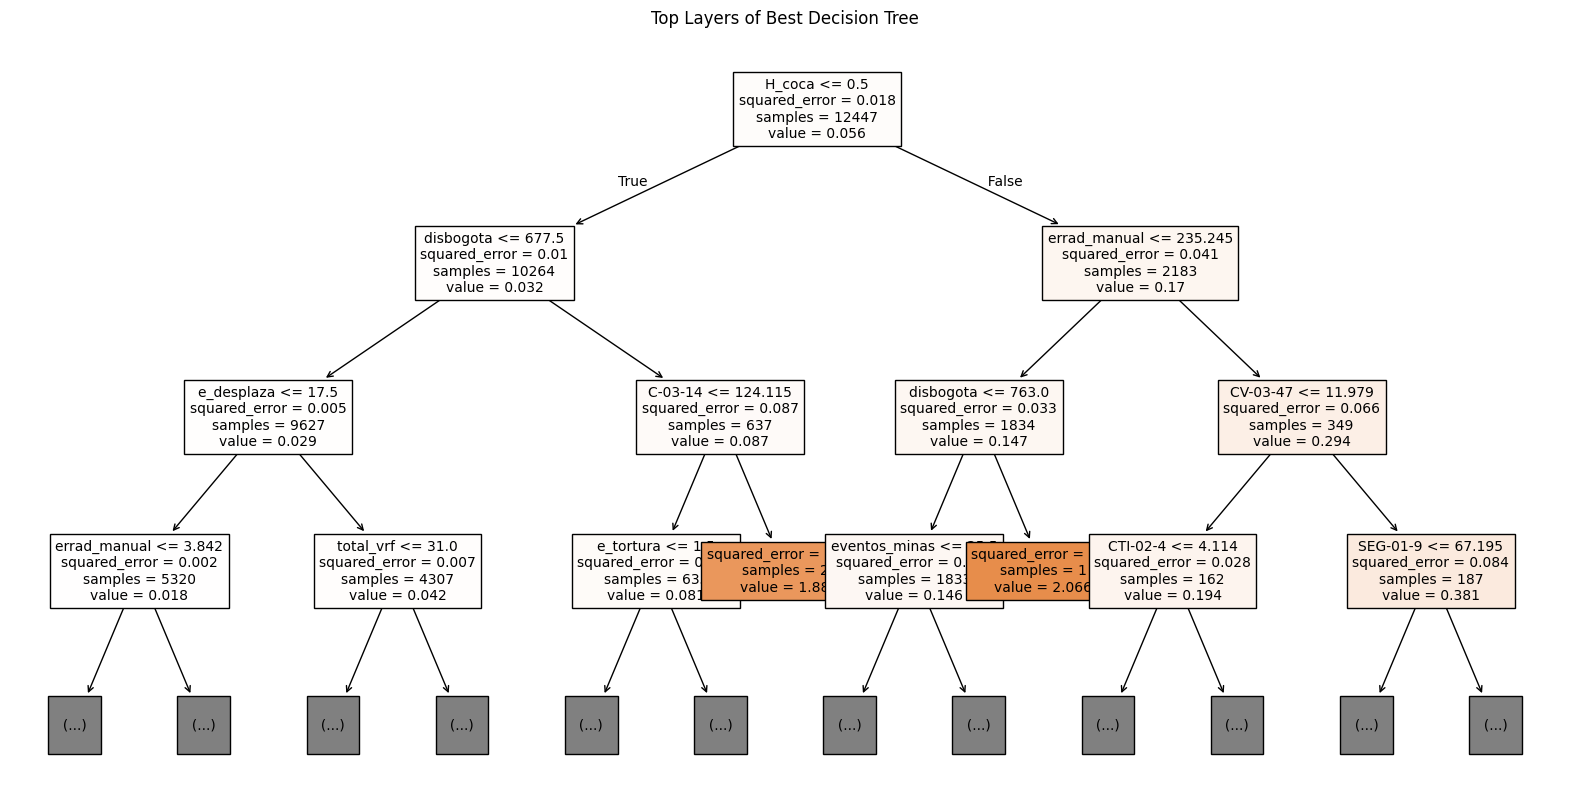

({'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10},
 {'MSE': np.float64(0.007805269248772993),
  'RMSE': np.float64(0.08792819124731095),
  'MAE': np.float64(0.04091929031999527),
  'R2_train': np.float64(0.7390801344947816),
  'R2_test': np.float64(0.3671496078285849),
  'Adj_R2_train': np.float64(0.7374327215423051),
  'Adj_R2_test': np.float64(0.3247205447084994)})

In [12]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Print tree structure info
print("Number of leaves:", best_model.get_n_leaves())
print("Tree depth:", best_model.get_depth())

# Plot tree
plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=X1.columns, filled=True, max_depth=3, fontsize=10)
plt.title("Top Layers of Best Decision Tree")
plt.show()

# Display final best parameters and metrics
best_params, best_metrics

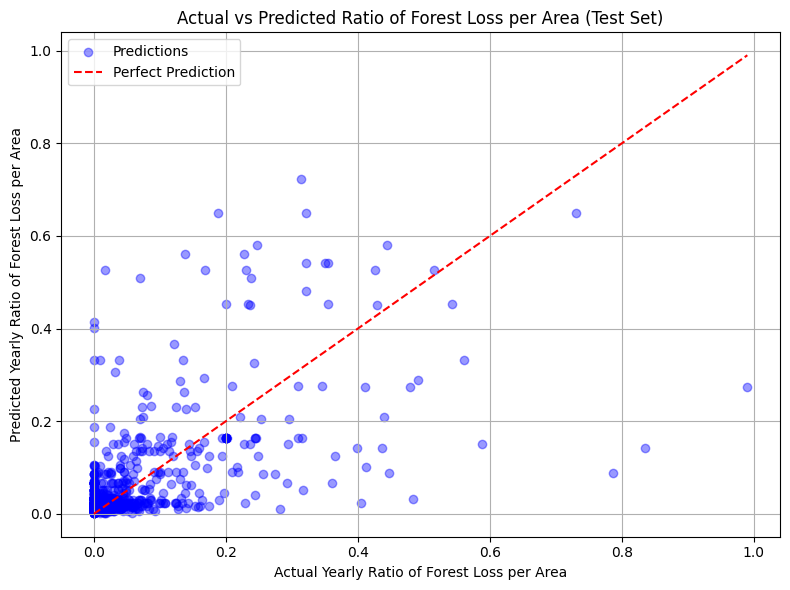

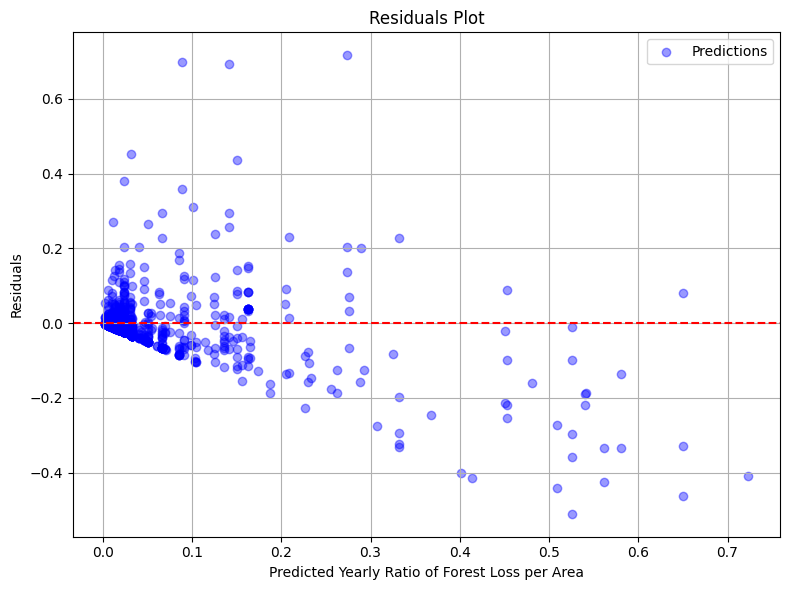

In [13]:
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.4, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Yearly Ratio of Forest Loss per Area")
plt.ylabel("Predicted Yearly Ratio of Forest Loss per Area")
plt.title("Actual vs Predicted Ratio of Forest Loss per Area (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.4, color='blue', label='Predictions')
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel("Predicted Yearly Ratio of Forest Loss per Area")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Decision tree - mena absolut SHAP values (Top 10 Features)')

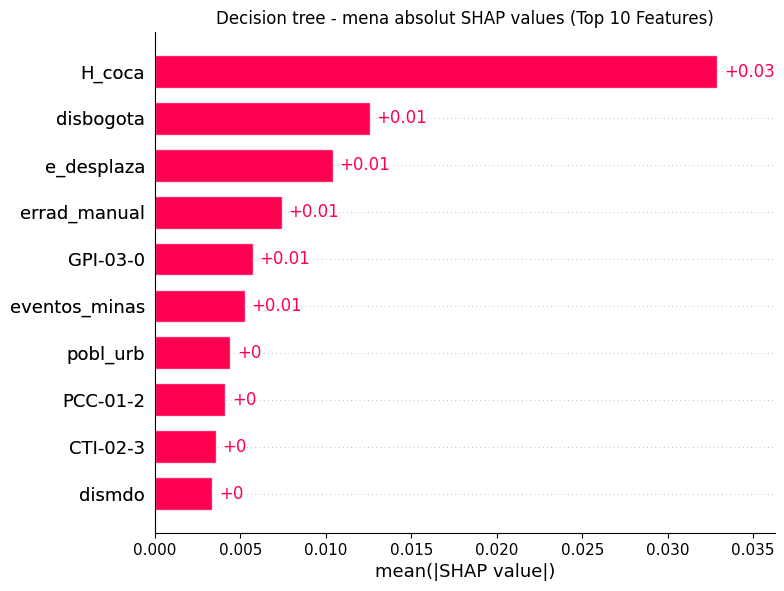

In [14]:
# 🔹 Compute SHAP Values for Feature Importance
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X1_train)

# Compute mean absolute SHAP values for each feature
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)

# Get indices of the top 10 features
top_10_indices = np.argsort(shap_abs_mean)[-10:]
top_10_indices

# Filter SHAP values to keep only the top 10 features
shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top_10_indices],  # Keep only top 10 values
    base_values=shap_values.base_values,  # Keep base values
    data=shap_values.data[:, top_10_indices],  # Keep only top 10 feature data
    feature_names=[original_feature_names[i] for i in top_10_indices]  # Correct feature names
)


# Plot the bar chart without "other features"
shap.plots.bar(shap_values_top10, show=False)
plt.title("Decision tree - mena absolut SHAP values (Top 10 Features)")
# “The absolute contribution of coca crops to the model’s predictions corresponds to an average shift of about 0.02 on the log(1 + yearly forest loss per capita) scale, 
# which translates to roughly a 2% multiplicative effect on (1 + yearly forest loss per capita).”


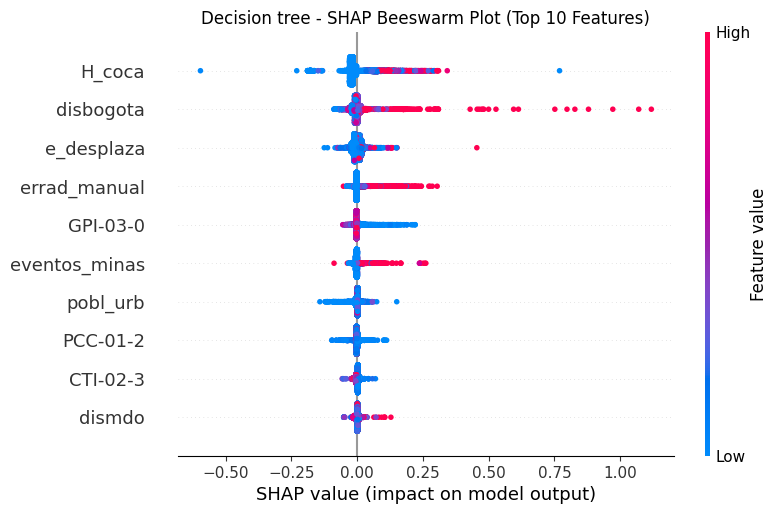

In [16]:
plt.figure(figsize=(16, 10))  
shap.plots.beeswarm(shap_values_top10, show=False)
plt.title("Decision tree - SHAP Beeswarm Plot (Top 10 Features)")
plt.show()
# “For some observations with high values of H_coca, the model’s prediction of yearly forest loss per capita can be up to about 25% higher than the model’s baseline 
# prediction (once we convert the SHAP value from the log(1 + y) scale back to the original scale).”

In [17]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define model
model = ExtraTreesRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=17,
    n_jobs=-1
)

# Set up panel split
panel_split = PanelSplit(periods=final_df['year'], n_splits=3, gap=0, test_size=1)

results_et = []

# Cross-validation
for train_idx, test_idx in panel_split.split(X1, y):
    X_train, X_test = X1.iloc[train_idx], X1.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    n_train, k = X_train.shape
    n_test = X_test.shape[0]
    adj_r2_train = 1 - (1 - r2_train) * ((n_train - 1) / (n_train - k - 1))
    adj_r2_test = 1 - (1 - r2_test) * ((n_test - 1) / (n_test - k - 1))

    results_et.append({
        "MSE": mse, "RMSE": rmse, "MAE": mae,
        "R2_train": r2_train, "R2_test": r2_test,
        "Adj_R2_train": adj_r2_train, "Adj_R2_test": adj_r2_test
    })

# Average results across folds
avg_results_et = {metric: np.mean([fold[metric] for fold in results_et]) for metric in results_et[0].keys()}

# Print summary
print(f"🌲 Extra Trees Performance (avg across folds):")
print(f"📊 MSE: {avg_results_et['MSE']:.4f}")
print(f"📊 RMSE: {avg_results_et['RMSE']:.4f}")
print(f"📊 MAE: {avg_results_et['MAE']:.4f}")
print(f"📊 R² (Train): {avg_results_et['R2_train']:.4f}")
print(f"📊 R² (Test): {avg_results_et['R2_test']:.4f}")
print(f"📊 Adj. R² (Train): {avg_results_et['Adj_R2_train']:.4f}")
print(f"📊 Adj. R² (Test): {avg_results_et['Adj_R2_test']:.4f}")


🌲 Extra Trees Performance (avg across folds):
📊 MSE: 0.0049
📊 RMSE: 0.0691
📊 MAE: 0.0397
📊 R² (Train): 0.7676
📊 R² (Test): 0.6199
📊 Adj. R² (Train): 0.7662
📊 Adj. R² (Test): 0.5944
